In [ ]:
!unzip data.zip 

Archive:  data.zip
replace data/beach/beach01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import cv2 
import utils 

%matplotlib inline 

# Clustering 
Using clustering to identify a smaller set of points for prediction.  Turn the regression problem into a classification problem.  

## Data wrangling 

In [68]:
import glob 

# filenames = glob.glob('data/beach_with_tree/*.jpg')
filenames = glob.glob('data/cat/orange/*.jpg')
filenames

['data/cat/orange/cat04.jpg',
 'data/cat/orange/cat02.jpg',
 'data/cat/orange/cat07.jpg',
 'data/cat/orange/cat03.jpg',
 'data/cat/orange/cat01.jpg',
 'data/cat/orange/cat05.jpg',
 'data/cat/orange/cat06.jpg',
 'data/cat/orange/cat08.jpg']

`imgs` is a list of all utils.Image objects from the above list 

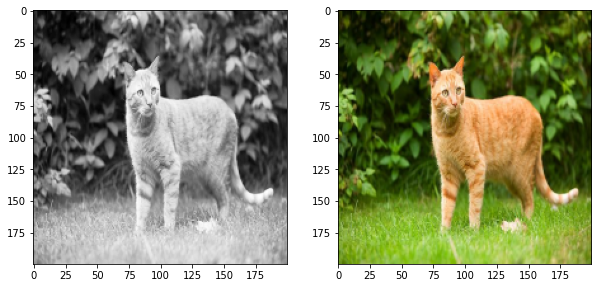

In [69]:
dim = 200
padding = 55

imgs = []

for idx, file in enumerate(filenames): 
    imgs.append(utils.Image(filenames[idx], resize=dim, padding=padding))

    
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(-imgs[0].gray_nopadding, cmap=plt.get_cmap('Greys'))
axes[1].imshow(cv2.cvtColor(imgs[0].data_nopadding, cv2.COLOR_BGR2RGB))

## Identify cluster using kmeans 

In [70]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [86]:
img = imgs[0].data_nopadding/255
n_colors = 12


w, h, d = tuple(img.data.shape)

image_array = np.reshape(img, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)

kmeans = KMeans(n_clusters=n_colors, random_state = 0, verbose=0).fit(image_array_sample)

In [87]:
clusters  = kmeans.cluster_centers_

clusters = np.array(clusters)

indeces_of_nearest_cluster = kmeans.predict(image_array)
indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))

In [88]:
new_image  = np.zeros(shape = (w,h,d))
for row in range(w):
    for col in range(h):
        new_image[row, col, 0] = clusters[indeces_of_nearest_cluster[row, col], 0]
        new_image[row, col, 1] = clusters[indeces_of_nearest_cluster[row, col], 1]
        new_image[row, col, 2] = clusters[indeces_of_nearest_cluster[row, col], 2]
        
        
new_image = (new_image*255).astype('uint8')

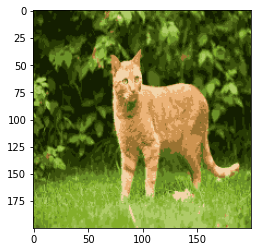

In [89]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

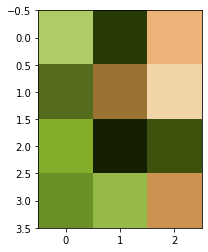

In [90]:
colors = (clusters*255).reshape(4, -1, 3).astype('uint8')
plt.imshow(cv2.cvtColor(colors, cv2.COLOR_BGR2RGB))

## Converting RGB to one-hot encoding 
Do this for all images in `imgs` list 

In [91]:
y = [] 

for img in imgs: 

    img = img.data_nopadding/255

    w, h, d = tuple(img.data.shape)

    image_array = np.reshape(img, (w * h, d))
    
    indeces_of_nearest_cluster = kmeans.predict(image_array)
    indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))
    
    utils.get_onehotencoding_vectors(indeces_of_nearest_cluster, n_colors, y) 
       

y = np.array(y)
w_size = 15 
X, _ = utils.imgs_to_dataset(filenames, resize=dim, padding=padding, window_size=w_size, squeeze=False)

In [92]:
X.shape, y.shape

((320000, 15, 15), (320000, 12))

In [93]:
X = utils.normalize(X)

train, test split 

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=2019)

In [95]:
X_train.shape, y_train.shape

((316800, 15, 15), (316800, 12))

## Model building 

In [96]:
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, Flatten 

In [97]:
# dim fix for conv 
X_train = np.expand_dims(X_train, axis=-1)

In [100]:
model = tf.keras.Sequential([ 
    Conv2D(10, kernel_size=(6, 6), padding='same', input_shape=(w_size, w_size, 1)), 
    Conv2D(20, kernel_size=(4, 4), padding='valid'), 
    Flatten(), 
    Dense(50, activation='relu'), 
    Dense(n_colors, activation='softmax')
])


In [119]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy')  

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 15, 15, 10)        370       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 20)        3220      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                144050    
_________________________________________________________________
dense_13 (Dense)             (None, 12)                612       
Total params: 148,252
Trainable params: 148,252
Non-trainable params: 0
_________________________________________________________________


In [120]:
EPOCHS=50 

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    validation_split=0.1, 
                    # callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)],
                    verbose=2)

Epoch 1/50
8910/8910 - 16s - loss: 0.8173 - val_loss: 0.8480
Epoch 2/50
8910/8910 - 15s - loss: 0.7736 - val_loss: 0.7680
Epoch 3/50
8910/8910 - 15s - loss: 0.7515 - val_loss: 0.7451
Epoch 4/50
8910/8910 - 15s - loss: 0.7398 - val_loss: 0.7420
Epoch 5/50
8910/8910 - 15s - loss: 0.7291 - val_loss: 0.7454
Epoch 6/50
8910/8910 - 15s - loss: 0.7227 - val_loss: 0.7596
Epoch 7/50
8910/8910 - 15s - loss: 0.7173 - val_loss: 0.7407
Epoch 8/50
8910/8910 - 15s - loss: 0.7123 - val_loss: 0.7347
Epoch 9/50
8910/8910 - 15s - loss: 0.7089 - val_loss: 0.7390
Epoch 10/50
8910/8910 - 15s - loss: 0.7067 - val_loss: 0.7508
Epoch 11/50
8910/8910 - 15s - loss: 0.7034 - val_loss: 0.7251
Epoch 12/50
8910/8910 - 15s - loss: 0.7003 - val_loss: 0.7351
Epoch 13/50
8910/8910 - 15s - loss: 0.6977 - val_loss: 0.7402
Epoch 14/50
8910/8910 - 15s - loss: 0.6965 - val_loss: 0.7671
Epoch 15/50
8910/8910 - 15s - loss: 0.6956 - val_loss: 0.7493
Epoch 16/50
8910/8910 - 15s - loss: 0.6935 - val_loss: 0.7332
Epoch 17/50
8910/

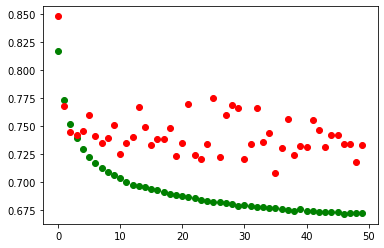

In [121]:
l = history.history['loss']
l_v = history.history['val_loss']


x_ = np.arange(len(l))
plt.scatter(x_, l, c='g') 
plt.scatter(x_, l_v, c='r') 

## Test on image 

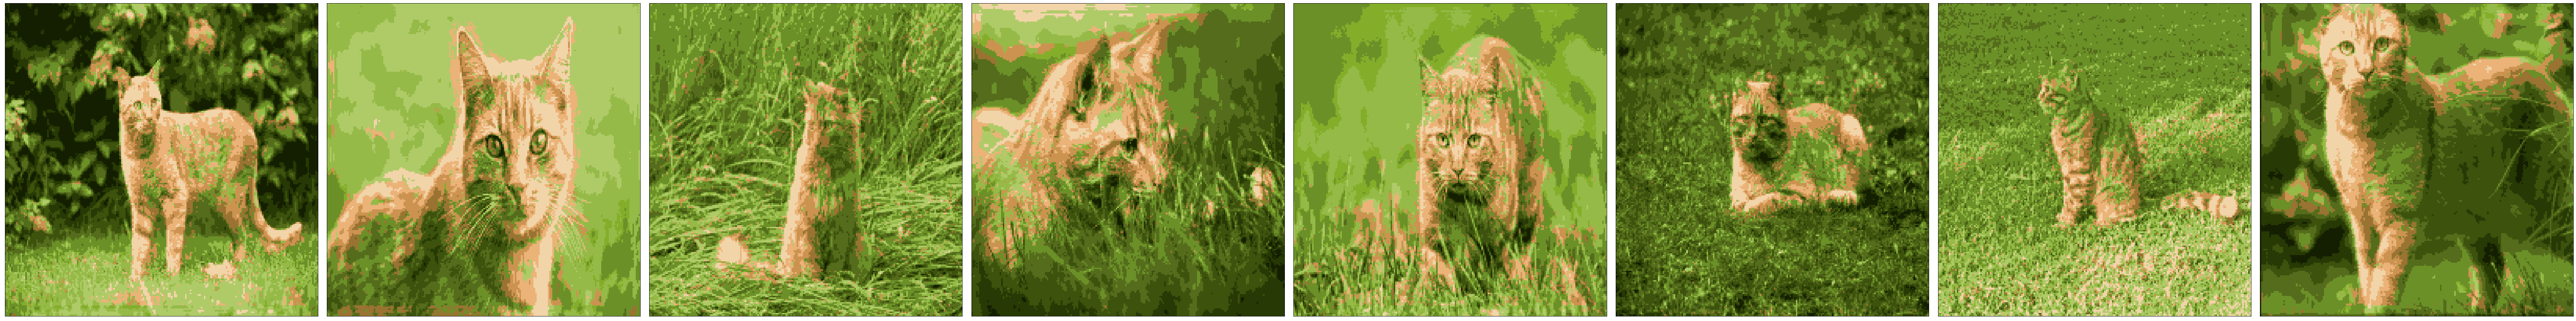

In [122]:
# img = imgs[2]
# img = utils.Image('data/cat/cat02.jpg', resize=dim, padding=50) 

fig, ax = plt.subplots(1, len(imgs), figsize=(10*len(imgs), 10))


for idx, img in enumerate(imgs): 

  X_test, _  = utils.img_to_dataset(img, squeeze=False, window_size=w_size) 

  X_test = np.array(X_test)
  X_test = np.expand_dims(X_test, axis=-1)
  X_test = utils.normalize(X_test)
  y_model = model.predict(X_test)

  new_image  = np.zeros(shape = (y_model.shape[0], 3))

  for i in range(y_model.shape[0]):              
      new_image[i] = clusters[np.argmax(y_model[i, :])]
          
  new_image = (new_image*255).astype('uint8')
  new_image = new_image.reshape(dim, dim, 3)


  ax[idx].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

  ax[idx].axes.xaxis.set_visible(False)
  ax[idx].axes.yaxis.set_visible(False)

plt.tight_layout()

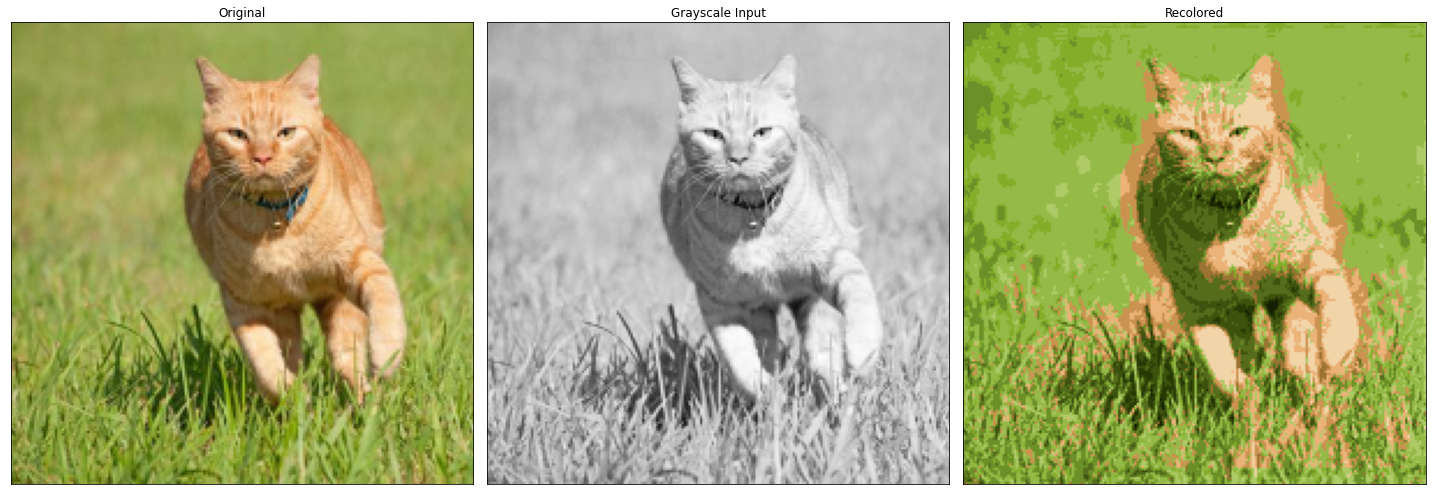

In [139]:
# img = imgs[4]
img = utils.Image('data/cat/oj-cat03.jpg', resize=dim, padding=50) 

X_test, _  = utils.img_to_dataset(img, squeeze=False, window_size=w_size) 

X_test = np.array(X_test)
X_test = np.expand_dims(X_test, axis=-1)
X_test = utils.normalize(X_test)
y_model = model.predict(X_test)


new_image  = np.zeros(shape = (y_model.shape[0], 3))

for i in range(y_model.shape[0]):              
    new_image[i] = clusters[np.argmax(y_model[i, :])]
        
new_image = (new_image*255).astype('uint8')
new_image = new_image.reshape(dim, dim, 3)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(img.data_nopadding, cv2.COLOR_BGR2RGB))
ax[1].imshow(-img.gray_nopadding, cmap=plt.get_cmap('Greys'))
ax[2].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

ax[0].set_title('Original')
ax[1].set_title('Grayscale Input')
ax[2].set_title('Recolored')

for a in ax: 
  a.axes.xaxis.set_visible(False)
  a.axes.yaxis.set_visible(False)

plt.tight_layout()

## Save Model 

In [76]:
model.save('20210121-wsize7')

INFO:tensorflow:Assets written to: 20210121-wsize7/assets


In [65]:
!zip -r 20210121-wsize7.zip 20210121-wsize7/

  adding: 20210121-wsize7/ (stored 0%)
  adding: 20210121-wsize7/variables/ (stored 0%)
  adding: 20210121-wsize7/variables/variables.index (deflated 63%)
  adding: 20210121-wsize7/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: 20210121-wsize7/saved_model.pb (deflated 88%)
  adding: 20210121-wsize7/assets/ (stored 0%)
